In [1]:
import pandas as pd
import tensorflow as tf
import seaborn

from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

from sent_functions import get_sent_flair as s_flair
from sent_functions import get_sent_nltk as s_nltk
from sent_functions import get_sent_textblob as s_textblob
from sent_functions import tokenize

c:\Users\thel0\OneDrive\Desktop\Sent Analysis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\thel0\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
SEED = 0

In [3]:
#tqdm progress bar for pandas methods
tqdm.pandas()

In [4]:
# Read in data
df = pd.read_csv('data_test.csv', sep='\t')

In [5]:
# Sampling (optional)
df = df.sample(n=10000, random_state = SEED)

In [6]:
df.head()

,sent,text,data_len,token_lens
99614,0,things not any better huh,5,7
173311,1,no prob my friend smartarsery is appreciated h...,14,19
190574,1,have fun on flashy fed hillim sure youre impor...,16,23
191962,1,algum viu isso eminem bruno no mtv awards,8,14
135321,0,i know i want guess i just need to order it on...,12,14


### Model Comparison

We start by applying the out-of-the-box sentiment analysis functions (s_flair, s_nltk, s_textblob) on our test data.

In [7]:
df['flair_sent'] = df['text'].progress_apply(s_flair)
df['nltk_sent'] = df['text'].progress_apply(s_nltk)
df['textblob_sent'] = df['text'].progress_apply(s_textblob)

100%|██████████| 10000/10000 [00:01<00:00, 6989.63it/s]


Initializing DistilBert model

In [8]:
model = TFDistilBertForSequenceClassification.from_pretrained('training_dummy')

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at training_dummy.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [9]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [10]:
MAX_LEN = 128

In [11]:
test_input_ids, test_attention_masks = tokenize(df.text.values, max_len=MAX_LEN)

100%|██████████| 10000/10000 [00:02<00:00, 3581.90it/s]


In [12]:
y = df['sent']

In [13]:
results = model.evaluate([test_input_ids,test_attention_masks], y, batch_size=128)

79/79 [==============================] - 17s 165ms/step - loss: 0.2353 - accuracy: 0.9085


In [14]:
plot_keys = ['flair', 'nltk', 'textblob', 'DistilBert']
plot_data = [accuracy_score(df['sent'], df['flair_sent']),
             accuracy_score(df['sent'], df['nltk_sent']),
             accuracy_score(df['sent'], df['textblob_sent']),
             results[1]
             ]

df_acc = pd.DataFrame({'model_name': plot_keys, 'accuracy': plot_data})

In [15]:
df_acc.head()

,model_name,accuracy
0,flair,0.7043
1,nltk,0.6544
2,textblob,0.6225
3,DistilBert,0.9085


(0.2, 1.0)

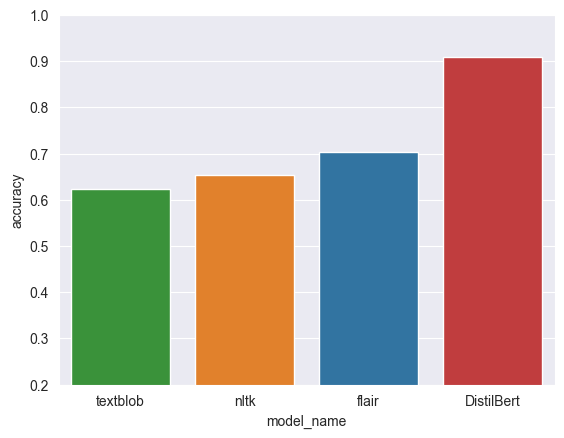

In [16]:
seaborn.set_style("darkgrid")

acc_plot = seaborn.barplot(
    data=df_acc,
    x='model_name',
    y='accuracy',
    order=df_acc.sort_values('accuracy').model_name,
    hue='model_name'
)

acc_plot.set_ylim(0.2, 1)